In [1]:
import torch
import numpy as np
import random
from datasets import load_dataset
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
dataset = load_dataset("glue", "sst2")

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [5]:
train = pd.DataFrame(dataset["train"])
validation = pd.DataFrame(dataset["validation"])
test = pd.DataFrame(dataset["test"])

In [6]:
train['tokenized'] = train['sentence'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
validation['tokenized'] = validation['sentence'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [7]:
train['token_len'] = train['tokenized'].apply(lambda x: len(x))
validation['token_len'] = validation['tokenized'].apply(lambda x: len(x))

In [8]:
max_len = 64
train = train[train['token_len'] <= max_len]
validation = validation[validation['token_len'] <= max_len]

In [9]:
max_len = 64
 
def pad_sequence(tokens, max_len):
    
    if len(tokens) < max_len:
        tokens.extend([0] * (max_len - len(tokens)))
    # Truncate if it's longer than max_len
    else:
       print(f"token length is equal to or greater than max_seq({max_len}) : -- {len(tokens)} -- {tokens}")
       tokens = tokens[:max_len]
    if len(tokens) != max_len:
        print(f"Padded sequence does not match max_len({max_len}) : {len(tokens)}")
    return tokens

In [10]:
train['padded_tokens'] = train['tokenized'].apply(lambda x: pad_sequence(x, max_len))
validation['padded_tokens'] = validation['tokenized'].apply(lambda x: pad_sequence(x, max_len))

token length is equal to or greater than max_seq(64) : -- 64 -- [101, 2045, 2024, 1050, 1005, 1056, 2205, 2116, 3152, 2008, 2064, 2022, 2004, 7453, 6057, 1010, 2125, 19442, 1998, 2540, 9028, 6562, 1006, 2302, 1037, 4317, 14021, 4168, 2906, 1997, 1996, 27571, 1010, 2012, 2560, 1007, 1010, 2021, 1036, 1036, 3449, 2989, 1005, 1005, 9020, 2000, 2079, 2035, 2093, 3243, 2092, 1010, 2437, 2009, 2028, 1997, 1996, 2095, 1005, 1055, 2087, 22249, 7085, 102]


In [11]:
from torch.utils.data import Dataset

class BERT_DataLoader(Dataset):
    def __init__(self, dataframe, pad_token=tokenizer.pad_token_id):
        self.dataframe = dataframe
        self.pad_token = pad_token 

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]["sentence"]
        input_ids = torch.tensor(self.dataframe.iloc[idx]["padded_tokens"], dtype=torch.long)
        label = torch.tensor(self.dataframe.iloc[idx]["label"], dtype=torch.long)

        seq_len = input_ids.size(0)

        # Step 1: Create key padding mask: shape [seq_len]
        key_padding = (input_ids != self.pad_token).int()

        # Step 2: Expand to [1, seq_len] and then outer product → [1, seq_len, seq_len]
        pad_mask = key_padding.unsqueeze(0) & key_padding.unsqueeze(1)  # [seq_len, seq_len]
        pad_mask = pad_mask.unsqueeze(0).int()  # Final shape: [1, seq_len, seq_len]

        return {
            "text": text,
            "input_ids": input_ids.clone(),      # [seq_len]
            "pad_mask": pad_mask.clone(),        # [1, seq_len, seq_len]
            "label": label                        # scalar
        }

In [12]:
from torch.utils.data import DataLoader
train_dataset = BERT_DataLoader(train)
dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_dataset = BERT_DataLoader(validation)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [33]:
for batch in dataloader:
    print(batch['text'])
    break

['hide new secretions from the parental units ', 'contains no wit , only labored gags ', 'that loves its characters and communicates something rather beautiful about human nature ', 'remains utterly satisfied to remain the same throughout ', 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ', "that 's far too tragic to merit such superficial treatment ", 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ', 'of saucy ']


BASE MODEL ARCHITECTURE

In [13]:
set_seed(42)
vocab_size = len(tokenizer.get_vocab())
d_model = 256
n_heads = 4
d_ff = 1024
n_layers_for_base_model =  4
n_layers_for_Xper_model =  3
dropout = 0.1
n_class = 2

In [14]:
#BASE MODEL ARCHITECTURE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch.nn as nn
import math
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=64):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model  # Embedding vector size
        self.h = h  # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h  # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False)  # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False)  # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False)  # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False)  # Wo
        self.dropout = nn.Dropout(dropout)
        self.attn_weights = None  # To store attention weights if needed

    def forward(self, q, k, v, mask, return_attention_weights):
        # Apply linear transformations to the inputs
        query = self.w_q(q)  # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k)  # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v)  # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # Reshape to (batch, seq_len, h, d_k) and then transpose to (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)
    
        mask = mask.to(torch.bool)  
        attn_output = F.scaled_dot_product_attention(query, key, value, attn_mask=mask)
        
        attn_output = attn_output.transpose(1, 2).contiguous().view(attn_output.shape[0], -1, self.h * self.d_k)
        output = self.w_o(attn_output)

        if return_attention_weights == True:
            scores = torch.matmul(query, key.transpose(-2, -1)) / self.d_k**0.5
            self.attn_weights = torch.softmax(scores, dim=-1)
            
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

class Block(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(Block, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, tgt_mask, return_attention_weights):
        self_attn_output = self.self_attn(x ,x, x, tgt_mask, return_attention_weights)
        x = self.norm1(x + self.dropout(self_attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class Transformer(nn.Module):
    def __init__(self, n_class, output_dim, d_model, n_heads, d_ff, n_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len=64)
        self.layers = nn.ModuleList([Block(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.fc_out = nn.Linear(d_model, n_class)
        
    def forward(self, tgt, tgt_mask, return_attention_weights =False):
        x = self.embedding(tgt)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, tgt_mask, return_attention_weights)
        cls_token = x[:, 0, :]
        return self.fc_out(cls_token)
  
Bert_base_model = Transformer(n_class, vocab_size, d_model, n_heads, d_ff, n_layers_for_base_model, dropout).to(device)

Using device: cuda


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch.nn as nn
import math
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=64):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model  # Embedding vector size
        self.h = h  # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h  # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False)  # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False)  # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False)  # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False)  # Wo
        self.dropout = nn.Dropout(dropout)
        self.attn_weights = None  # To store attention weights if needed

    def forward(self, q, k, v, mask, return_attention_weights = False):
        # Apply linear transformations to the inputs
        query = self.w_q(q)  # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k)  # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v)  # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # Reshape to (batch, seq_len, h, d_k) and then transpose to (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)
    
        mask = mask.to(torch.bool)  
        attn_output = F.scaled_dot_product_attention(query, key, value, attn_mask=mask)
        
        attn_output = attn_output.transpose(1, 2).contiguous().view(attn_output.shape[0], -1, self.h * self.d_k)
        output = self.w_o(attn_output)
        if return_attention_weights == True:
            scores = torch.matmul(query, key.transpose(-2, -1)) / self.d_k**0.5
            self.attn_weights = torch.softmax(scores, dim=-1)
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

class Block(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(Block, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, tgt_mask):
        self_attn_output = self.self_attn(x ,x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class FinalSingleHeadAttention(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FinalSingleHeadAttention, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, 1, dropout)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, tgt_mask, return_attention_weights):
        self_attn_output = self.self_attn(x ,x, x, tgt_mask, return_attention_weights)
        x = self.norm1(x + self.dropout(self_attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class Transformer(nn.Module):
    def __init__(self, n_class, output_dim, d_model, n_heads, d_ff, n_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len=64)
        self.layers = nn.ModuleList([Block(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.final_atten = FinalSingleHeadAttention(d_model, d_ff, dropout)
        self.fc_out = nn.Linear(d_model, n_class)
        
    def forward(self, tgt, tgt_mask, return_attention_weights = False):
        x = self.embedding(tgt)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, tgt_mask)
        x = self.final_atten(x, tgt_mask, return_attention_weights)
        cls_token = x[:, 0, :]
        return self.fc_out(cls_token)

Xper_model = Transformer(n_class, vocab_size, d_model, n_heads, d_ff, n_layers_for_Xper_model, dropout).to(device)

Using device: cuda


In [16]:
from num2words import num2words

def number_to_words(num):
    # Convert number to words in Indian numbering system
    return num2words(num, lang='en_IN')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) 
# Assuming 'model' is your PyTorch model

total_params = count_parameters(Xper_model)
print(f"Total model parameters: {total_params} -- {number_to_words(total_params)}")

Total model parameters: 10969090 -- one crore, nine lakh, sixty-nine thousand and ninety


In [54]:
def copy_weights(source_model, target_model):
    source_dict = source_model.state_dict()
    target_dict = target_model.state_dict()

    # Copy only the matching keys (layer names must match)
    for name in source_dict:
        if name in target_dict and source_dict[name].shape == target_dict[name].shape:
            target_dict[name] = source_dict[name].clone()

    target_model.load_state_dict(target_dict)
copy_weights(Bert_base_model, Xper_model)

In [65]:
for (name_a, param_a), (name_b, param_b) in zip(Bert_base_model.named_parameters(), Xper_model.named_parameters()):
    if name_a == name_b:
        same = torch.equal(param_a, param_b)
        print(f"{name_a}: {'✅ same' if same else '❌ different'}")

embedding.weight: ✅ same
layers.0.self_attn.w_q.weight: ✅ same
layers.0.self_attn.w_k.weight: ✅ same
layers.0.self_attn.w_v.weight: ✅ same
layers.0.self_attn.w_o.weight: ✅ same
layers.0.ff.linear1.weight: ✅ same
layers.0.ff.linear1.bias: ✅ same
layers.0.ff.linear2.weight: ✅ same
layers.0.ff.linear2.bias: ✅ same
layers.0.norm1.weight: ✅ same
layers.0.norm1.bias: ✅ same
layers.0.norm2.weight: ✅ same
layers.0.norm2.bias: ✅ same
layers.1.self_attn.w_q.weight: ✅ same
layers.1.self_attn.w_k.weight: ✅ same
layers.1.self_attn.w_v.weight: ✅ same
layers.1.self_attn.w_o.weight: ✅ same
layers.1.ff.linear1.weight: ✅ same
layers.1.ff.linear1.bias: ✅ same
layers.1.ff.linear2.weight: ✅ same
layers.1.ff.linear2.bias: ✅ same
layers.1.norm1.weight: ✅ same
layers.1.norm1.bias: ✅ same
layers.1.norm2.weight: ✅ same
layers.1.norm2.bias: ✅ same
layers.2.self_attn.w_q.weight: ✅ same
layers.2.self_attn.w_k.weight: ✅ same
layers.2.self_attn.w_v.weight: ✅ same
layers.2.self_attn.w_o.weight: ✅ same
layers.2.ff.lin

In [66]:
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader 
from tqdm import tqdm
import os
import warnings

epochs = 10
lr = 10**-4
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)

def train_model(model, load_path, save_path ):

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if device == 'cuda':
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")

    checkpoint_path = load_path
    initial_epoch = 0

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-9)
    loss_fn = nn.CrossEntropyLoss().to(device)

    # Load checkpoint if available
    if os.path.exists(checkpoint_path):
        print("Checkpoint found. Loading model and optimizer state...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        initial_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
        print(f"Model loaded from checkpoint. Resuming from epoch {initial_epoch + 1}.")
    else:
        print("Checkpoint not found. Training from scratch.")

    for epoch in range(initial_epoch, epochs):
        torch.cuda.empty_cache()
        model.train()
        total_loss = 0  # To track loss
        i = 0
        batch_iterator = tqdm(train_dataloader, desc=f"Processing Epoch {epoch+1:02d}")
        for batch in batch_iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['pad_mask'].to(device)
            targets = batch['label'].to(device)

            # Forward pass
            output = model(input_ids, attention_mask)
            loss = loss_fn(output, targets)
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            total_loss += loss.item()
            i += 1
        # Save model checkpoint with epoch number and optimizer state
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, save_path)

        print(f"Checkpoint saved at epoch {epoch + 1}.")
        #run_validation(model, custom_tokenizer, 16, device, lambda msg: batch_iterator.write(msg))
if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    train_model(Bert_base_model, "Bert_Param.pth", "BERT_Params.pth")

Using device: cuda
Device name: NVIDIA GeForce GTX 1060 6GB
Device memory: 5.999755859375 GB
Checkpoint not found. Training from scratch.


Processing Epoch 01: 100%|██████████| 2105/2105 [01:24<00:00, 25.06it/s, loss=0.397]


Checkpoint saved at epoch 1.


Processing Epoch 02: 100%|██████████| 2105/2105 [01:23<00:00, 25.19it/s, loss=0.171]


Checkpoint saved at epoch 2.


Processing Epoch 03: 100%|██████████| 2105/2105 [01:24<00:00, 24.85it/s, loss=0.141]


Checkpoint saved at epoch 3.


Processing Epoch 04: 100%|██████████| 2105/2105 [01:25<00:00, 24.61it/s, loss=0.120]


Checkpoint saved at epoch 4.


Processing Epoch 05: 100%|██████████| 2105/2105 [01:25<00:00, 24.70it/s, loss=0.040]


Checkpoint saved at epoch 5.


Processing Epoch 06: 100%|██████████| 2105/2105 [01:26<00:00, 24.26it/s, loss=0.106]


Checkpoint saved at epoch 6.


Processing Epoch 07: 100%|██████████| 2105/2105 [01:24<00:00, 24.82it/s, loss=0.063]


Checkpoint saved at epoch 7.


Processing Epoch 08: 100%|██████████| 2105/2105 [01:25<00:00, 24.55it/s, loss=0.017]


Checkpoint saved at epoch 8.


Processing Epoch 09: 100%|██████████| 2105/2105 [01:25<00:00, 24.63it/s, loss=0.007]


Checkpoint saved at epoch 9.


Processing Epoch 10: 100%|██████████| 2105/2105 [01:24<00:00, 25.01it/s, loss=0.013]


Checkpoint saved at epoch 10.


In [73]:
if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    train_model(Xper_model, "Bert_Param.pth", "BERT_3_+_1_single_Params.pth")

Using device: cuda
Device name: NVIDIA GeForce GTX 1060 6GB
Device memory: 5.999755859375 GB
Checkpoint not found. Training from scratch.


Processing Epoch 01: 100%|██████████| 2105/2105 [01:33<00:00, 22.63it/s, loss=0.494]


Checkpoint saved at epoch 1.


Processing Epoch 02: 100%|██████████| 2105/2105 [02:05<00:00, 16.76it/s, loss=0.457]


Checkpoint saved at epoch 2.


Processing Epoch 03: 100%|██████████| 2105/2105 [01:41<00:00, 20.78it/s, loss=0.217]


Checkpoint saved at epoch 3.


Processing Epoch 04: 100%|██████████| 2105/2105 [02:03<00:00, 17.08it/s, loss=0.230]


Checkpoint saved at epoch 4.


Processing Epoch 05: 100%|██████████| 2105/2105 [01:47<00:00, 19.67it/s, loss=0.091]


Checkpoint saved at epoch 5.


Processing Epoch 06: 100%|██████████| 2105/2105 [01:55<00:00, 18.22it/s, loss=0.032]


Checkpoint saved at epoch 6.


Processing Epoch 07: 100%|██████████| 2105/2105 [01:56<00:00, 18.09it/s, loss=0.131]


Checkpoint saved at epoch 7.


Processing Epoch 08: 100%|██████████| 2105/2105 [01:56<00:00, 18.12it/s, loss=0.005]


Checkpoint saved at epoch 8.


Processing Epoch 09: 100%|██████████| 2105/2105 [01:40<00:00, 20.93it/s, loss=0.004]


Checkpoint saved at epoch 9.


Processing Epoch 10: 100%|██████████| 2105/2105 [01:41<00:00, 20.72it/s, loss=0.013]


Checkpoint saved at epoch 10.


In [20]:
def pad_mask_function(input_ids, pad_token=0):
    key_padding = (input_ids != pad_token).int()
    pad_mask = key_padding.unsqueeze(0) & key_padding.unsqueeze(1)  # [seq_len, seq_len]
    pad_mask = pad_mask.unsqueeze(0).int()  # Final shape: [1, seq_len, seq_len]
    return pad_mask

In [25]:
checkpoint1 = torch.load("BERT_Params.pth")
Bert_base_model.load_state_dict(checkpoint1['model_state_dict'])
checkpoint2 = torch.load("BERT_3_+_1_single_Params.pth")
Xper_model.load_state_dict(checkpoint2['model_state_dict'])

<All keys matched successfully>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

def predict_and_visualize_dual_models(
    text, 
    tokenizer, 
    model_base, 
    model_modified, 
    pad_mask_function, 
    max_len=64, 
    device="cpu"
):
    models = {
        "Base BERT": model_base,
        "Modified BERT": model_modified
    }
    
    # Tokenize once
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=max_len, truncation=True)
    token_in_sep_ids = tokenizer.convert_ids_to_tokens(tokens)
    token_in_sep_ids = token_in_sep_ids[1:-1]
    input_ids = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    pad_mask = pad_mask_function(input_ids, pad_token=0).to(device)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    for i, (label, model) in enumerate(models.items()):
        model.eval()
        with torch.no_grad():
            output = model(input_ids, pad_mask, return_attention_weights=True)
            probs = F.softmax(output, dim=1).squeeze()
            
            if label == "Modified BERT":
                attention = model.final_atten.self_attn.attn_weights.squeeze(0).squeeze(0)
                attention = attention[1:-1, 1:-1] 
                
            else:
                attention = model.layers[-1].self_attn.attn_weights.squeeze(0)  
                attention = attention.mean(0).squeeze(0)  
                attention = attention[1:-1, 1:-1] 


        pred_class = torch.argmax(probs).item()
        sentiment = "Positive" if pred_class == 1 else "Negative"
        
        sns.heatmap(attention.cpu().numpy(), 
                    xticklabels=token_in_sep_ids,
                    yticklabels=token_in_sep_ids,
                    cmap='viridis',
                    ax=axes[i])
        
        axes[i].set_title(f"{label}\nPrediction: {sentiment} ({probs[pred_class]:.4f})", fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=0)

    fig.suptitle(f"Sentence: \"{text}\"", fontsize=14)
    plt.tight_layout()
    plt.show()


Tokenized input: ['the', 'movie', 'was', 'surprisingly', 'good']


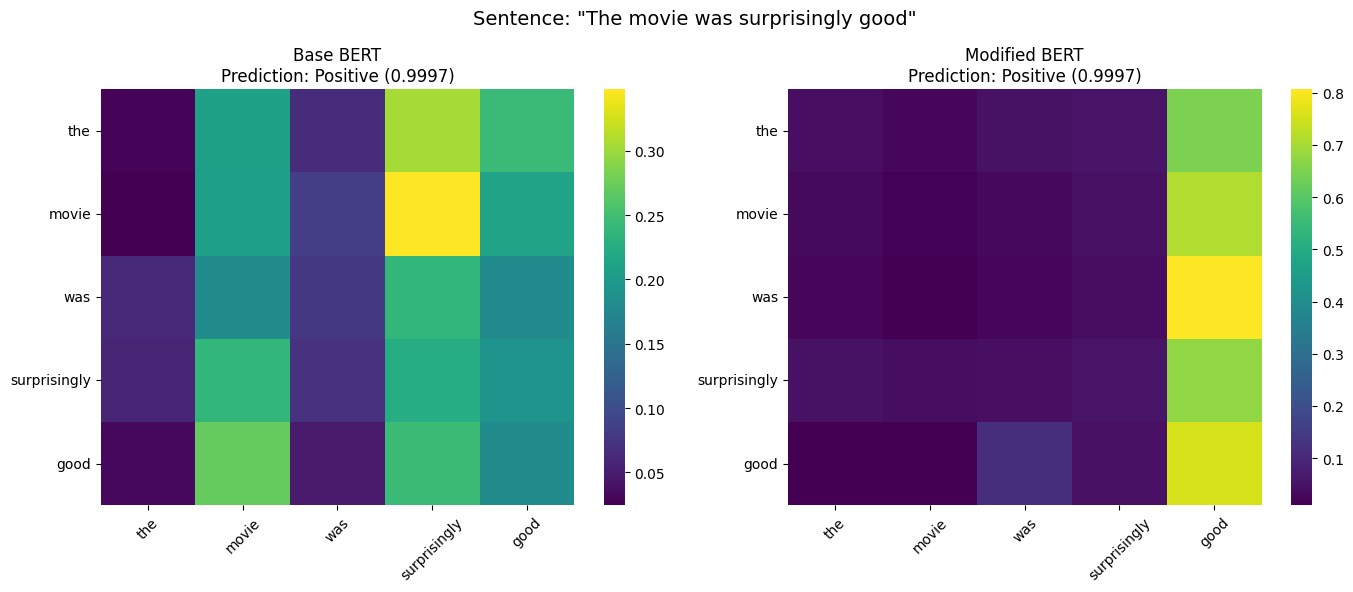

In [65]:
predict_and_visualize_dual_models(
    text="The movie was surprisingly good",
    tokenizer=tokenizer,
    model_base = Bert_base_model,
    model_modified = Xper_model,
    pad_mask_function = pad_mask_function,
    device="cuda" if torch.cuda.is_available() else "cpu"
)


In [95]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch.nn.functional as F
import numpy as np
import torch

def evaluate_model(model, val_dataloader, device, class_names=["Negative", "Positive"]):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['pad_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            logits = outputs
            preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names)

    print(f"\n✅ Validation Accuracy: {accuracy:.4f}")
    print("\n📊 Confusion Matrix:")
    print(conf_matrix)
    print("\n📈 Classification Report:")
    print(report)

    return accuracy, conf_matrix, report

In [96]:
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [97]:
acc, cm, report = evaluate_model(Xper_model, val_dataloader, device)


✅ Validation Accuracy: 0.7970

📊 Confusion Matrix:
[[348  80]
 [ 97 347]]

📈 Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.81      0.80       428
    Positive       0.81      0.78      0.80       444

    accuracy                           0.80       872
   macro avg       0.80      0.80      0.80       872
weighted avg       0.80      0.80      0.80       872



In [100]:
acc, cm, report = evaluate_model(Bert_base_model, val_dataloader, device)


✅ Validation Accuracy: 0.7890

📊 Confusion Matrix:
[[334  94]
 [ 90 354]]

📈 Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.78      0.78       428
    Positive       0.79      0.80      0.79       444

    accuracy                           0.79       872
   macro avg       0.79      0.79      0.79       872
weighted avg       0.79      0.79      0.79       872

